# Candlestick formation - batched
in this notebook we will take our raw data and do the following:

1. Import and review the data - check if there are any missing values, etc 
2. Test a sample candle stick formation using our ```candle_stick.py``` script 
3. Creating our candlestick data using the same script and saving it in our ```model_data``` directory under ```image_data```

We will be importing our local ```omegacandlestick.py``` module which will automatically import other appropriate tools

In [1]:
from omegacandlestick import *

## 1. Dataset pre-processing
The first thing we will do is download our raw csv and perform some pre-processing via the notebook. Many of the helper scripts via omega are general therefor any pre-processing will happen outside those modules.

In [2]:
# grabbing our file
file = f'{os.curdir}/raw_data/'
file = f'{file}/{os.listdir(file)[0]}' # grabbing our first file - initial download

file

'./raw_data//GBP_USD_H1_2016-01-01_2018-01-01.csv'

In [3]:
# loading our data into a dataframe
headers = ['date', 'complete', 'open', 'high', 'low', 'close', 'volume']

my_dtypes = {
    'date': 'str',
    'complete': 'bool',
    'open': 'float',
    'high': 'float',
    'low': 'float',
    'close': 'float',
    'volume': 'float'
}

my_parse_dates = ['date']

df = pd.read_csv(file, names=headers, dtype=my_dtypes, parse_dates=my_parse_dates)

In [4]:
# dropping complete column
df.drop(columns='complete', axis=1, inplace=True)

# # re-arranging
df = df[['date', 'open', 'high', 'low', 'close', 'volume']]

In [5]:
df.head()

,date,open,high,low,close,volume
0,2016-01-03 22:00:00,1.47352,1.47464,1.47351,1.47354,1068.0
1,2016-01-03 23:00:00,1.47343,1.47382,1.47266,1.47356,938.0
2,2016-01-04 00:00:00,1.47364,1.47412,1.47240,1.47278,570.0
3,2016-01-04 01:00:00,1.47284,1.47301,1.46936,1.47177,1133.0
4,2016-01-04 02:00:00,1.47183,1.47234,1.47041,1.47184,865.0


In [6]:
df.tail()

,date,open,high,low,close,volume
12403,2017-12-29 17:00:00,1.35278,1.35362,1.35224,1.35240,3945.0
12404,2017-12-29 18:00:00,1.35242,1.35254,1.35181,1.35248,2445.0
12405,2017-12-29 19:00:00,1.35240,1.35248,1.35158,1.35178,2180.0
12406,2017-12-29 20:00:00,1.35178,1.35180,1.35008,1.35010,2257.0
12407,2017-12-29 21:00:00,1.35012,1.35112,1.34951,1.35045,2593.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12408 entries, 0 to 12407
Data columns (total 6 columns):
date      12408 non-null datetime64[ns]
open      12408 non-null float64
high      12408 non-null float64
low       12408 non-null float64
close     12408 non-null float64
volume    12408 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 581.7 KB


In [8]:
# Setting date to datetime
df['date'] = pd.to_datetime(df['date'])

## 2. DF Split
Given the size of our dataframe, we will create ```len(df)``` images. Therefor because of memory we will actually split the dataframe in half using ```batch_split_two``` from our script 

In [9]:
?batch_split_two

Signature: batch_split_two(df_)
Docstring:
This is a simple function that will split a large df into two different dataframes in half. Considering Used mainly for testing
ARGS:
    df_: <pandas dataframe object> - time series dataframe
File:      c:\users\dmber\documents\omega\omegadev\model_z\omegacandlestick.py
Type:      function


In [10]:
# getting our split batches
df1, df2 = batch_split_two(df)

In [11]:
df1.tail(1)

,date,open,high,low,close,volume
6203,736328.416667,1.23124,1.23162,1.22874,1.23042,2194.0


In [12]:
df2.head(1)

,date,open,high,low,close,volume
6204,736328.458333,1.23037,1.23101,1.22864,1.23026,1055.0


## 3. Testing our Plotting - using ```omegacandlestick.py```
We will now test our candlestick formation and test ```candle_width``` size.

In [13]:
?candlestick_test

Signature: candlestick_test(df_, window_size, candle_width=0.015)
Docstring:
This is a test function which will return a sample candlestick plot 
ARGS:
    df_: <pandas dataframe object> - time series dataframe
    window_size: <int> - the window size. If you select 15 and each timestep is 1hr, then the window size is 15hrs
    candle_width: <float> - width of the candlestick - you may need to play around with this number and 'eye it'
File:      c:\users\dmber\documents\omega\omegadev\model_z\omegacandlestick.py
Type:      function


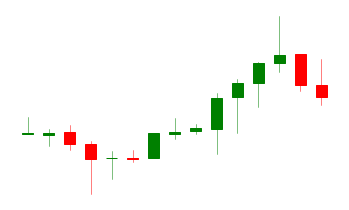

In [14]:
ws = 15 # window size
cw = 0.022 # candle width

candlestick_test(df, window_size=ws, candle_width=cw)

## 4. Saving images with ```save_images``` function
Now we will use our function ```save_images``` from our ```omegacandlestick.py``` module. We will be using multiprocessing for this 'process'

In [15]:
?save_images_multi

Signature:
save_images_multi(
    df_,
    save_path,
    buy_percentage,
    sell_percentage,
    window_size=15,
    target_size=3,
    candle_size=0.022,
)
Docstring:
This function will be our worker function - take a dataframe along with the save_path and other parameters to create a dataset of buy, sell, and hold images. Buys and sells will be labeled above and below thresholds respectively while anything in between will be a hold


ARGS:
    df_: <pandas dataframe object>
    save_path: <string> - where we will store all our images
    window_size: <int> - how many timesteps will a window consist of: if you select 15, and each timestep is 1hr, then the window size will be 15hr
    target_size: <int> - how far off are we labeling an projecting? If you select 3, then we are labeling on the 18th (if the window size is 15)
    candle_size: <float> - the size of each candle
    buy_percentage: <float> - how much of an increase in price from window end to target for the image to be lab